In [2]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import pickle

# .py
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE
sys.path.append("../Data")
from Load_plot_data import load_neuron_data, roster_plot

In [3]:
#Load data
ids,times=load_neuron_data('../Data/Cellline1_Date190328_Chip2135.npz')
N=np.max(ids) # Number of neurons

In [4]:
Yspike=[]
for i in range(N):
    Yspike.append(times[ids==i])
print(len(Yspike))


1016


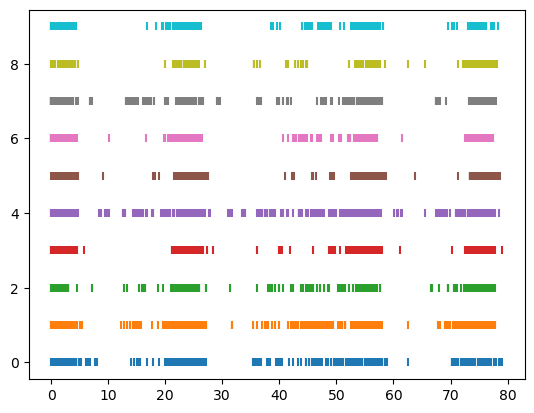

In [5]:
#Reduce the dataset (only one trial)
N=10
timemax=80

#Yspike=Yspike[0][:N] #keep only n first neuron

#seeds
torch.manual_seed(24)
np.random.seed(11) #C,d (very bad seed : 26,20)
random.seed(27) #neuron choice

#keep n most actives
Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)[:3*N]
#print(Yspike[-1].shape[0])
random.shuffle(Yspike) #There is a problem when just the N first are taken (not semidefinite positive qsigma)
Yspike=Yspike[:N]

#keep n not too actives but not 0
#Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)
#print(Yspike[800].shape[0])
#random.shuffle(Yspike) #There is a problem when just the N first are taken (not semidefinite positive qsigma)
#Yspike=Yspike[:N]

for i in range(N):  #reduce the time
    Yspike[i]=Yspike[i][Yspike[i]<=timemax]
    plt.scatter(Yspike[i],i*np.ones(Yspike[i].shape[0]),marker='|')
plt.show()

In [6]:
np.histogram(Yspike[0])

(array([67, 10, 40, 27, 17, 28, 71, 24, 11, 60], dtype=int64),
 array([6.5500000e-03, 7.9088550e+00, 1.5811160e+01, 2.3713465e+01,
        3.1615770e+01, 3.9518075e+01, 4.7420380e+01, 5.5322685e+01,
        6.3224990e+01, 7.1127295e+01, 7.9029600e+01]))

In [34]:
def gaussian(x,sigma):
    """ delta_t represent the spacing between two histogram bins"""
    return 1./np.sqrt( 2. * np.pi * sigma**2 ) * np.exp( -x**2 / ( 2. * sigma**2 ) )

    

def spike_to_ditribution(Yspike,tmax,delta_t,sigma, kernel_size):
    """Yspike : list of array where array i contains the times at which neuron i had a spike"""
    new_data=[]
    nmb_bins=int(tmax/delta_t)
    for neuron in range(len(Yspike)):
        hist, bin=np.histogram(Yspike[neuron],bins=nmb_bins)
        Gaussian_filter=np.fromiter((gaussian(x,sigma) for x in (-kernel_size,kernel_size+1,1)),dtype=np.float64)
        
        Gaussian_filter= Gaussian_filter * delta_t / np.sum(Gaussian_filter)
        if np.sum(Gaussian_filter * delta_t) !=1:
            print( "not normalized")
            print(Gaussian_filter)

        Convolved_data=np.convolve(hist,Gaussian_filter,mode='same')
        Convolved_data[Convolved_data<=10**(-50)]=10**(-50)
        new_data.append(Convolved_data)
    
    return new_data

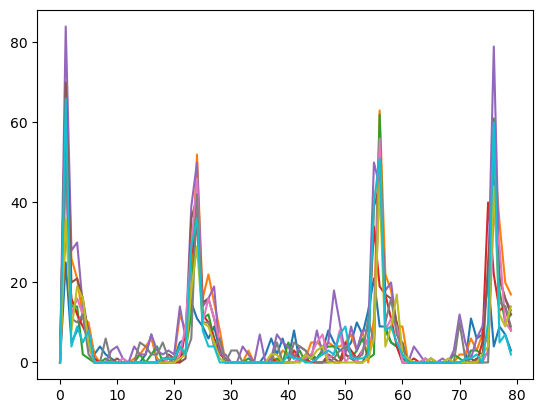

In [35]:
Yspike_distr=spike_to_ditribution(Yspike,timemax,1,0.1,5)
for spikeneuron in Yspike_distr:
    plt.plot(spikeneuron)
plt.show()